# MNIST 2.2

This document serves as my notes on the Deep Learning Without a PhD seminar by Google. 

* [Video](https://www.youtube.com/watch?v=vq2nnJ4g6N0)
* [Slides - 1](https://docs.google.com/presentation/d/1TVixw6ItiZ8igjp6U17tcgoFrLSaHWQmMOwjlgQY9co/pub?slide=id.p)
* [Slides - 2](https://docs.google.com/presentation/d/e/2PACX-1vRouwj_3cYsmLrNNI3Uq5gv5-hYp_QFdeoan2GlxKgIZRSejozruAbVV0IMXBoPsINB7Jw92vJo2EAM/pub?slide=id.p)

This notebook covers the fourth example, of trying to classify MNIST digits using:
* 5 fully connected layers
* with ReLu activations
* Learning Rate Decay
* **Dropout**

# Setup

## Imports

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import math
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Load Data

In [2]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


## Setup Model

In this noteboo, we're going to use 5 fully connected layers:

![](images/5-layers.png)

* take each $28 \times 28$ image, flatten into a $784$ vector
* have that fully connected to a $200$ node ReLu layer
* have that fully connected to a $100$ node ReLu layer
* have that fully connected to a $60$ node ReLu layer
* have that fully connected to a $30$ node ReLu layer
* have that fully connected to a $10$ node softmax layer - this is the classification/output layer

In this example, our intermdiate "hidden" layers are using a ReLu activation function:

![](images/relu.png)

We will also be using **dropout**:

![](images/dropout.png)

**Note: ** We dont want dropout activated during training. We control toggling this setting using the `probKeep` variable:

In [3]:
probKeep = tf.placeholder(tf.float32, name="Prob_Keep")

Here we define a global variable to control the dropout prob in the training step below: 

In [4]:
PROBKEEP = 0.75

Lets define all our sizes up front for clarity

In [5]:
batchSize = None;       # put None for right now as we dont know yet

imgHeight = 28
imgWidth = 28
numOfColors = 1         # gray scale images

flatSize = imgHeight*imgWidth*numOfColors   # 728

numberOfClasses = 10    # 10 classes: 0-9

# Size of each layer:
sizeLayerOne = 200
sizeLayerTwo = 100
sizeLayerThree = 60
sizeLayerFour = 30
sizeLayerFive = numberOfClasses       # the final layer is the output layer

Lets begin with our our input images: `X_img`:

In [6]:
# Input Data
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")
X_vec = tf.reshape(X_img, [-1, 784], name="X_vec")

And the necessery placeholders:

In [7]:
Y_True = tf.placeholder(tf.float32, [batchSize, 10])

**Note:** We now have a placeholder for the learning rate

In [8]:
learningRate = tf.placeholder(tf.float32)

Now we define our weights, biases and activations *for each layer*. 

For the first layer we are connecting a vector of size $784$ to $200$ nodes. Programatically that means connecting `flatSize` to `sizeLayerOne`:

In [9]:
with tf.name_scope("Layer_1"):
    # Weights
    W1 = tf.Variable(tf.truncated_normal([flatSize, sizeLayerOne], stddev=0.1), name="Weights")

    # Biases
    b1 = tf.Variable(tf.zeros([sizeLayerOne]), name="Biases")
    
    # ReLu Activation
    Y1 = tf.nn.relu(tf.matmul(X_vec, W1) + b1, name="Activation")
    
    # Dropout
    Y1_Dropout = tf.nn.dropout(Y1, probKeep)

In [10]:
with tf.name_scope("Layer_2"):
    # Weights
    W2 = tf.Variable(tf.truncated_normal([sizeLayerOne, sizeLayerTwo], stddev=0.1), name="Weights")

    # Biases
    b2 = tf.Variable(tf.zeros([sizeLayerTwo]), name="Biases")
    
    # ReLu Activation - Working on previous layers Dropout
    Y2 = tf.nn.relu(tf.matmul(Y1_Dropout, W2) + b2, name="Activation")
    
    # Dropout
    Y2_Dropout = tf.nn.dropout(Y2, probKeep)

In [11]:
with tf.name_scope("Layer_3"):
    # Weights
    W3 = tf.Variable(tf.truncated_normal([sizeLayerTwo, sizeLayerThree], stddev=0.1), name="Weights")

    # Biases
    b3 = tf.Variable(tf.zeros([sizeLayerThree]), name="Biases")
    
    # ReLu Activation - Working on previous layers Dropout
    Y3 = tf.nn.relu(tf.matmul(Y2_Dropout, W3) + b3, name="Activation")
    
    # Dropout
    Y3_Dropout = tf.nn.dropout(Y3, probKeep)

In [12]:
with tf.name_scope("Layer_4"):
    # Weights
    W4 = tf.Variable(tf.truncated_normal([sizeLayerThree, sizeLayerFour], stddev=0.1), name="Weights")

    # Biases
    b4 = tf.Variable(tf.zeros([sizeLayerFour]), name="Biases")
    
    # ReLu Activation - Working on previous layers Dropout
    Y4 = tf.nn.relu(tf.matmul(Y3_Dropout, W4) + b4, name="Activation")
    
    # Dropout
    Y4_Dropout = tf.nn.dropout(Y4, probKeep)

Now we have the output layer

In [13]:
with tf.name_scope("Output_Layer"):
    # Weights
    W5 = tf.Variable(tf.truncated_normal([sizeLayerFour, sizeLayerFive], stddev=0.1), name="Weights")

    # Biases
    b5 = tf.Variable(tf.zeros([sizeLayerFive]), name="Biases")
    
    # Output logits - Working on previous layers Dropout
    Y_logits = tf.matmul(Y4_Dropout, W5) + b5
    
    # Softmax Activation
    Y_Pred = tf.nn.softmax(Y_logits, name="Activation")

**Note:** The cross-entropy loss function is 

$$ - \sum \left( \tilde{Y}_i \cdot \log(Y_i) \right)$$

TensorFlow provides the `softmax_cross_entropy_with_logits` function to avoid numerical stability problems with `log(0)` which is `NaN`, so we use that instead below, *normalized for batches of $100$ images*

In [14]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_True)
cross_entropy = tf.reduce_mean(cross_entropy)*100

We define our accuracy metric:

In [15]:
# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y_Pred, 1), tf.argmax(Y_True, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

And now the training step using the `Adam` Optimizer **with a variable for the learning rate!**

In [16]:
# training step
trainStep = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

Now we can continue as before:

In [17]:
numberOfBatches = 10000+1
batchSize = 100

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

Here we specify the **rate of decay** of our learning rate! 

In [18]:
maxLearningRate = 0.003
minLearningRate = 0.0001
decaySpeed = 2000.0   # 0.003-0.0001-2000=>0.9826 done in 5000 iterations

At each new batch, our new learning rate will then be:

$$\texttt{minLR} + \left( \texttt{maxLR} - \texttt{minLR} \right) \cdot \exp{\frac{-\texttt{batchNumber}}{\texttt{decaySpeed}}}$$

In [20]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # calculate new learning rate for this batch:
        learning_Rate = minLearningRate + (maxLearningRate - minLearningRate) * math.exp(-i/decaySpeed)
    
        # setup this batches input dictionary
        #     - including the new learning rate
        #     - and the dropout/probKeep value
        train_data = {X_img: batch_X, Y_True: batch_Y, learningRate: learning_Rate, probKeep: PROBKEEP}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)
        
        # check our accuracy on training and test data 
        # while resetting dropout! 
        if i%100 == 0:
            # compute our success on the training data
            train_data_to_test_on = {X_img: batch_X, Y_True: batch_Y, learningRate: learning_Rate, probKeep: 1.0}
            trainAcc, trainLoss = sess.run([accuracy, cross_entropy], feed_dict=train_data_to_test_on)
    
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True: mnist.test.labels, probKeep: 1.0}
            testAcc,testLoss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
            # print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            # print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)
            
            print("Batch number: ",i, "lr: ", learning_Rate, "Test Loss: ", testLoss)

Batch number:  0 lr:  0.003 Test Loss:  228.971
Batch number:  100 lr:  0.0028585653310520707 Test Loss:  35.8031
Batch number:  200 lr:  0.0027240285123042826 Test Loss:  27.6968
Batch number:  300 lr:  0.0025960531316326675 Test Loss:  21.3113
Batch number:  400 lr:  0.0024743191839261473 Test Loss:  19.3898
Batch number:  500 lr:  0.002358522270907074 Test Loss:  18.0588
Batch number:  600 lr:  0.002248372839976982 Test Loss:  15.7987
Batch number:  700 lr:  0.002143595460184269 Test Loss:  16.0597
Batch number:  800 lr:  0.002043928133503354 Test Loss:  14.187
Batch number:  900 lr:  0.001949121639703143 Test Loss:  14.8597
Batch number:  1000 lr:  0.0018589389131666372 Test Loss:  12.8877
Batch number:  1100 lr:  0.0017731544501034114 Test Loss:  12.6911
Batch number:  1200 lr:  0.001691553744672677 Test Loss:  12.1938
Batch number:  1300 lr:  0.0016139327526069466 Test Loss:  11.2973
Batch number:  1400 lr:  0.0015400973809950877 Test Loss:  11.0855
Batch number:  1500 lr:  0.001

# Plotting

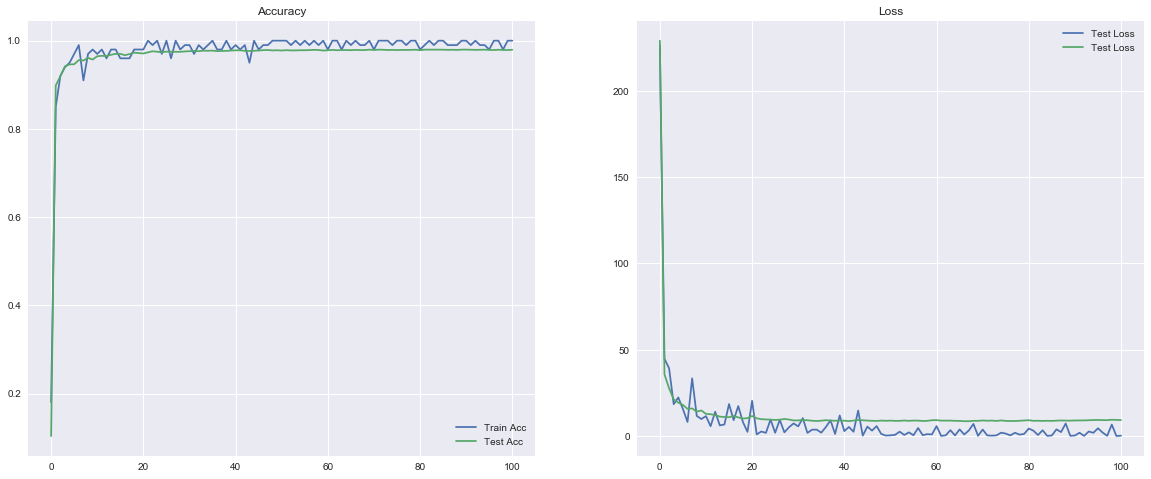

In [21]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

**Note:** I don't why we have that spike there! Maybe I coded up something incorrectly. Either way, lets have a look at just the tail of the plots:

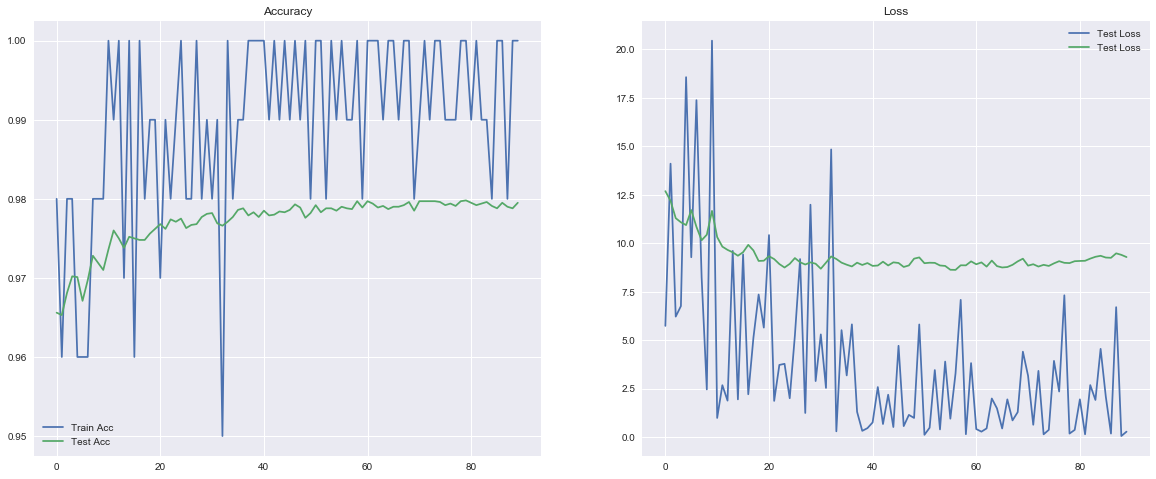

In [22]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss");
plt.title("Loss");
plt.legend();

# Save results

In [23]:
resultsDic = {"trainAcc": trainingAccuracyList, "trainLoss": trainingLossList, "testAcc": testAccuracyList, "testLoss": testLossList}

with open("results/mnist-2.2-results.txt", "wb") as fp:   #Pickling
    pickle.dump(resultsDic, fp)

# Compare with Previous Results

Below we compare with `MNIST-2.1`:

In [24]:
with open("results/mnist-2.1-results.txt", "rb") as rp:
    mnist21_resultsDic = pickle.load(rp)

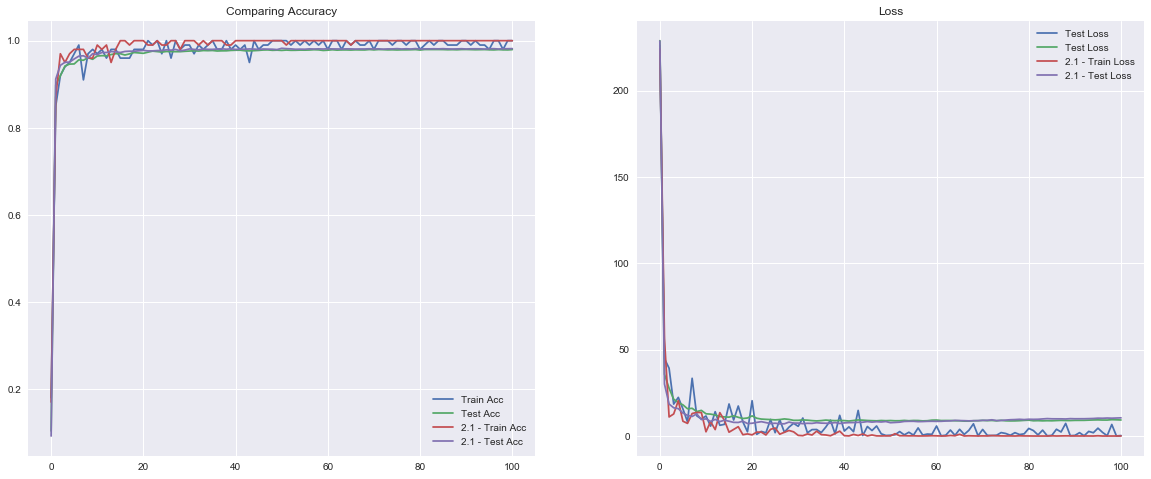

In [25]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");

plt.plot(mnist21_resultsDic["trainAcc"], label="2.1 - Train Acc");
plt.plot(mnist21_resultsDic["testAcc"], label="2.1 - Test Acc");

plt.title("Comparing Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");

plt.plot(mnist21_resultsDic["trainLoss"], label="2.1 - Train Loss");
plt.plot(mnist21_resultsDic["testLoss"], label="2.1 - Test Loss");

plt.title("Loss");
plt.legend();

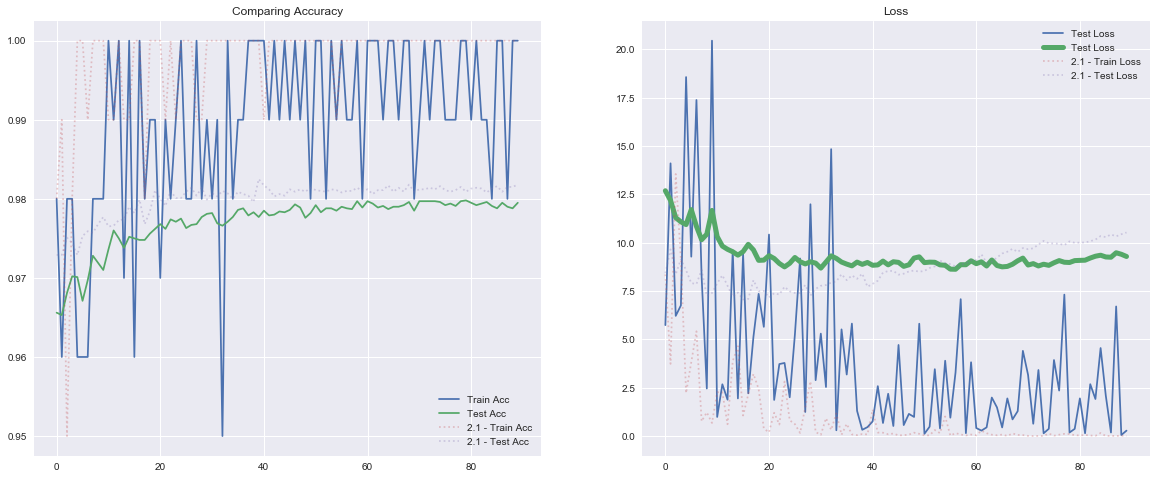

In [36]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");

plt.plot(mnist21_resultsDic["trainAcc"][tailLength:], label="2.1 - Train Acc", alpha=0.3, linestyle=':');
plt.plot(mnist21_resultsDic["testAcc"][tailLength:], label="2.1 - Test Acc", alpha=0.3, linestyle=':');

plt.title("Comparing Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss", linewidth=5);

plt.plot(mnist21_resultsDic["trainLoss"][tailLength:], label="2.1 - Train Loss", alpha=0.3, linestyle=':');
plt.plot(mnist21_resultsDic["testLoss"][tailLength:], label="2.1 - Test Loss", alpha=0.3, linestyle=':');

plt.title("Loss");
plt.legend();

**Note:** As we can see, our loss has evened out and not risen as training continued. However, we didnt get as low as the last time. 

We can't seem to break the 98% accuracy barrier - because we flattened all our images ignoring spatial information! 